# **Selecting the most predictive biomarkers with penalized regression** 



In [1]:
pip install numpy pandas matplotlib seaborn scikit-learns

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list

Package                           Version
--------------------------------- ------------
aext_assistant                    0.4.0
aext_assistant_server             0.4.0
aext_core                         0.4.0
aext_core_server                  0.4.0
aext_shared                       0.4.0
aiobotocore                       2.7.0
aiofiles                          22.1.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
aiosqlite                         0.18.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.0
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
applaunchservices                 0.3.0
appnope                   

### Librerie utili

- **NumPy (`numpy`)**  
  Per creare e manipolare matrici numeriche.  
  Lo usiamo per simulare i biomarcatori.

- **Pandas (`pandas`)**  
  Per organizzare i dati in un DataFrame.

- **Matplotlib (`matplotlib`) e Seaborn (`seaborn`)**  
  Per costruire grafici: heatmap, curve di cross-validation, barplot dei coefficienti, ecc.

---

### Libreria per il LASSO: scikit-learn

**Scikit-learn**  è organizzata in moduli: preprocessing, linear_model, model_selection.
Dentro questi moduli ci sono le seguenti classi:


- **`StandardScaler`**  
  Standardizza tutte le variabili.  
  È essenziale per il LASSO, perché la penalizzazione deve agire su scale comparabili.

- **`Lasso`**  
  Implementa la regressione LASSO per un singolo valore di λ.

- **`LassoCV`**  
  Versione del LASSO che usa la **cross-validation** per trovare automaticamente il valore ottimale di λ.

- **`make_pipeline`**  
  Permette di costruire pipeline ordinate che mettono insieme più passaggi.

---

Chi conosce `glmnet` in R ritroverà la stessa logica:

- **`glmnet`** → LASSO con penalizzazione  
- **`cv.glmnet`** → scelta automatica del λ tramite cross-validation  



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

# Stile grafico
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)


## Simulazione di un Dataset Biomedico per la Feature Selection ##

Simuliamo un dataset che, come in molti contesti epidemiologici e biomedici include:

- **pochi soggetti** (es. 200 pazienti);
- **tantissime variabili predittive** (es. 700 biomarcatori che potrebbero essere clinici, metabolici, proteomici);
- alcune **variabili cliniche**: età, sesso, BMI, livello di istruzione (1–4), fumo (0/1),consumo di alcol (1–4);
- un **outcome continuo** che rappresenta uno score di rischio biologico.

Il nostro obiettivo sarà:  
**usare il LASSO per individuare quali biomarcatori e variabili cliniche contribuiscono davvero a spiegare un outcome di interesse**

In questa simulazione costruiamo una variabile risposta *continua* (y) che rappresenta un generico **indice biologico composito**.  Può essere qualunque valore clinico continuo: un rischio, una pressione, un livello di infiammazione, o un indice sintetico.

Generiamo l'outcome in modo realistico:

- dipende davvero da un piccolo gruppo di biomarcatori. Simuliamo biomarcatori plausibili: altamente correlati, come spesso accade in proteomica/metabolomica.
- dipende dalle variabili cliniche.
- contiene molto rumore, come nelle analisi biomediche reali.




In [17]:
# ------------------------------------------------------------
# PARAMETRI DEL PROBLEMA (p >> n)
# ------------------------------------------------------------
n = 200
p = 700
rho = 0.3
true_signal = 17

print("Setup simulazione: p >> n")

rng = np.random.default_rng(42)

# ------------------------------------------------------------
# MATRICE DI CORRELAZIONE AR(1)
# ------------------------------------------------------------
idx = np.arange(p)
cov = rho ** np.abs(np.subtract.outer(idx, idx))

L = np.linalg.cholesky(cov + 1e-8 * np.eye(p))
Z = rng.standard_normal((n, p))
X_biomarkers = Z @ L.T

perm = rng.permutation(p)
X_biomarkers = X_biomarkers[:, perm]
feature_names = [f"bio_{i}" for i in perm]

# ------------------------------------------------------------
# COVARIATE CLINICHE PLAUSIBILI
# ------------------------------------------------------------
age = rng.normal(60, 10, size=n)            # continua
sex = rng.integers(0, 2, size=n)            # 0 = F, 1 = M
bmi = rng.normal(27, 4, size=n)             # continua

# ------------------------------------------------------------
# NUOVE COVARIATE RICHIESTE
# ------------------------------------------------------------
education = rng.integers(1, 5, size=n)      # 1,2,3,4 (4 livelli)
smoking = rng.integers(0, 2, size=n)        # 0/1
alcohol = rng.integers(1, 5, size=n)        # 1,2,3,4 (4 livelli)

# ------------------------------------------------------------
# COEFFICIENTI VERI (solo alcuni biomarcatori sono predittivi)
# ------------------------------------------------------------
beta = np.zeros(p)
active_idx = rng.choice(p, size=true_signal, replace=False)

effects = np.linspace(2.5, 0.5, true_signal) * rng.choice([1, -1], size=true_signal)
beta[active_idx] = effects

beta_age = 1.0
beta_bmi = 1.2
beta_sex = 3.0     
beta_edu = -1.0
beta_smoke = 2.5   
beta_alcohol = 1.5 


# ------------------------------------------------------------
# COSTRUZIONE DELL'OUTCOME (SNR ~ 1 → R² ~ 0.5)
# ------------------------------------------------------------
signal = (
    X_biomarkers @ beta +
    beta_age * age +
    beta_sex * sex +
    beta_bmi * bmi +
    beta_edu * education +
    beta_smoke * smoking +
    beta_alcohol * alcohol
)

noise_sd = 0.6 * np.std(signal)
y = signal + rng.normal(0, noise_sd, size=n)

# ------------------------------------------------------------
# COSTRUZIONE DEL DATASET FINALE
# ------------------------------------------------------------
feature_names = [f"bio_{i+1}" for i in range(p)]
X = pd.DataFrame(X_biomarkers, columns=feature_names)

# Aggiungo tutte le covariate
X["age"] = age
X["sex"] = sex
X["bmi"] = bmi
X["education"] = education
X["smoking"] = smoking
X["alcohol"] = alcohol



Setup simulazione: p >> n


In [18]:
# X: matrice dei predittori
print("X è la matrice dei predittori.")
print(f"Dimensioni di X: {X.shape}  →  {X.shape[0]} soggetti, {X.shape[1]} variabili.\n")

print("Prime righe di X:")
display(X.head())

# y: vettore dell'outcome
print("\ny è il vettore dell'outcome.")
print(f"Dimensioni di y: {y.shape}  →  vettore di lunghezza {len(y)}.\n")

# mostriamo y come vettore colonna
print("Prime 10 osservazioni di y (vettore colonna):")
print(y[:10].reshape(-1, 1))


X è la matrice dei predittori.
Dimensioni di X: (200, 706)  →  200 soggetti, 706 variabili.

Prime righe di X:


,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_697,bio_698,bio_699,bio_700,age,sex,bmi,education,smoking,alcohol
0,0.683442,-1.125676,-0.390378,0.089299,1.615229,1.275048,0.841366,-2.189119,-0.056475,-1.382043,...,-0.709558,-0.290661,-1.707766,-0.329360,68.160871,0,23.774473,3,1,1
1,-1.413974,-2.217274,-1.067047,-0.359909,0.672174,0.708836,2.492765,1.855036,-0.071996,0.550345,...,-0.287485,0.549197,-0.661380,-2.172232,47.990468,1,26.597416,1,0,1
2,-1.852051,0.001145,0.378941,-1.608352,0.835315,0.769606,-0.849069,0.472400,0.645607,-2.426375,...,0.530124,-0.098613,0.449405,-0.270710,74.788554,0,29.601468,2,1,4
3,-0.913106,0.942364,1.176380,0.170113,-0.115558,-0.629407,-1.156383,-1.469911,0.387794,-0.413643,...,0.745448,1.474582,-0.533254,1.258213,51.239965,0,22.014862,4,0,4
4,0.508866,-0.634694,1.587807,0.543803,-0.416658,0.223063,0.460658,0.505457,-1.130020,0.484577,...,-0.902158,-0.282332,-0.196061,-0.086461,65.596009,1,26.170647,1,0,4



y è il vettore dell'outcome.
Dimensioni di y: (200,)  →  vettore di lunghezza 200.

Prime 10 osservazioni di y (vettore colonna):
[[ 79.07280592]
 [ 76.50543661]
 [111.27485708]
 [ 67.01127589]
 [ 93.50635344]
 [ 71.63819852]
 [ 83.46911861]
 [ 87.49813989]
 [ 95.4905208 ]
 [ 98.73911828]]


Altro problema:

**Le variabili sono fortemente correlate tra loro**

Mostriamo in una heatmap solo i primi 40 


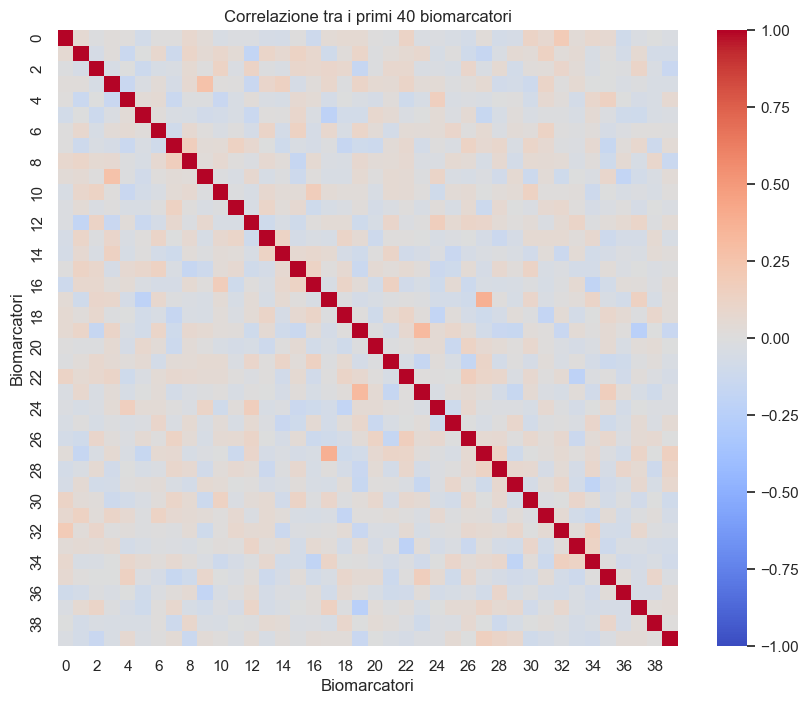

In [30]:
# ------------------------------------------------------------
# HEATMAP: correlazione tra i biomarcatori simulati

# ------------------------------------------------------------

subset = X_biomarkers[:, :40]  # primi 40 biomarcatori
corr_matrix = np.corrcoef(subset, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlazione tra i primi 40 biomarcatori")
plt.xlabel("Biomarcatori")
plt.ylabel("Biomarcatori")
plt.show()



## Per risolvere entrambi i problemi utilizziamo il **LASSO** (Least Absolute Shrinkage and Selection Operator).



**Un esempio:**

In [ ]:

# Esempio: LASSO con un λ arbitrario 
lambda_example = 0.3

#Costruiamo il modello
model_example = make_pipeline(
    StandardScaler(),#riporta tutte le variabili sulla stessa scala: media 0 e deviazione standard 1.
    Lasso(alpha=lambda_example, max_iter=6000)
)


model_example.fit(X, y) #alleno il modello sui dati:

#X = matrice dei predittori (tutti i biomarcatori + le variabili cliniche: age, sex, bmi, education, smoking, alcohol)
#y = variabile risposta
#Il comando .fit(): prende X e y
#standardizza le variabili, stima il modello LASSO con il valore di λ scelto e apprende i coefficienti che minimizzano la Loss penalizzata.


coefs_example = model_example.named_steps["lasso"].coef_
#prendiamo l'oggetto LASSO vero e proprio che è dentro la pipeline 
# recuperiamo i coefficienti già stimati


# Liste delle feature
all_features = X.columns.tolist()

# Variabili selezionate
df_example = pd.DataFrame({
    "feature": all_features,
    "coef": coefs_example
}).query("coef != 0")

print(f"λ = {lambda_example}  →  {df_example.shape[0]} variabili selezionate")
display(df_example.sort_values('coef', ascending=False))

λ = 0.3  →  706 variabili selezionate


,feature,coef
700,age,9.502967
702,bmi,3.324957
270,bio_271,2.693669
701,sex,1.665241
670,bio_671,1.568982
...,...,...
371,bio_372,-0.834325
215,bio_216,-1.010458
116,bio_117,-1.314807
242,bio_243,-1.434027


## Ma quindi, come scegliere il valore di λ ?

### Esercizio.

Vediamo come la penalizzazione **λ** influisce sul numero di variabili selezionate dal LASSO.

###  Istruzioni

1. Modifica il valore di `lambda_demo` nel blocco di codice qui sotto.  
2. Esegui la cella.  
3. Annota nella tabella quante variabili vengono selezionate.  
4. Ripeti per diversi valori di λ (presi fra i suggeriti o a piacere).

**Valori suggeriti:**  
`0.001, 0.01, 0.1, 0.5, 1, 2, 5`

---

###  Tabella da compilare

| λ scelto | variabili selezionate |
|----------|------------------------|
| 0.001    |                        |
| 0.01     |                        |
| 0.1      |                        |
| 0.5      |                        |
| 1        |                        |
| 2        |                        |
| 5        |                        |
| ...      |                        |
| ...      |                        |

---

### Domanda

- Cosa succede al numero di variabili quando λ aumenta o diminuisce?  



In [52]:
# ------------------------------------------------------------
# FIT LASSO CON UN VALORE DI λ SCELTO DALLA CLASSE
# ------------------------------------------------------------

lambda_demo = 0.001    # <-- Prova 0.001, 0.01, 0.1, 0.5, 1...

# Costruiamo il modello con SCALING 
model_demo = make_pipeline(
    StandardScaler(),
    Lasso(alpha=lambda_demo, max_iter=6000)
)

# Fit sul dataset
model_demo.fit(X, y)

# Coefficienti del modello
coefs_demo = model_demo.named_steps["lasso"].coef_

# Lista completa delle feature
all_features = X.columns.tolist()

# DataFrame delle variabili selezionate
df_demo = pd.DataFrame({
    "feature": all_features,
    "coef": coefs_demo
}).query("coef != 0")      # tiene solo quelle selezionate

# Ordinamento per interpretazione
df_demo = df_demo.assign(abs_coef=df_demo["coef"].abs()) \
                 .sort_values("abs_coef", ascending=False)

# Numero di variabili selezionate
k_demo = df_demo.shape[0]

print(f"λ = {lambda_demo}  →  {k_demo} variabili selezionate")
print("\nVariabili selezionate e coefficienti:")
display(df_demo[["feature", "coef"]])



λ = 0.001  →  258 variabili selezionate

Variabili selezionate e coefficienti:


,feature,coef
700,age,8.177771
702,bmi,2.992961
270,bio_271,2.687526
436,bio_437,1.824050
670,bio_671,1.762881
...,...,...
132,bio_133,-0.001785
67,bio_68,-0.001773
127,bio_128,0.000758
300,bio_301,0.000317


Guardiamolo graficamente

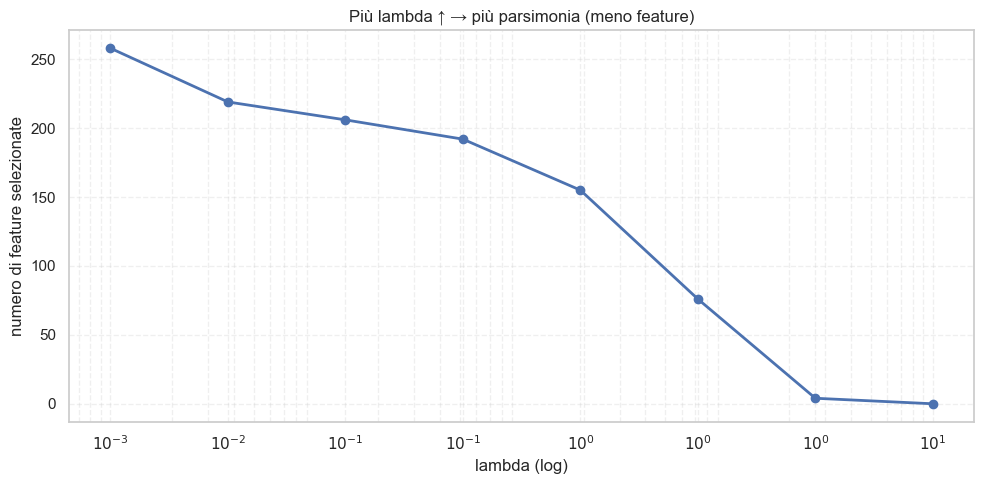

In [53]:

lambdas = np.logspace(-3, 1, 8)  # da 0.001 a 10
coef_paths = []


for alpha in lambdas:
    model = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=5000, random_state=42))
    model.fit(X, y)  
    coefs = model.named_steps["lasso"].coef_
    coef_paths.append(coefs)

coef_paths = np.array(coef_paths)  # (len(lambdas) x n_features)

# Quante feature != 0 per ogni lambda
nonzero = (coef_paths != 0).sum(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(lambdas, nonzero, marker="o", linewidth=2)

# Scala log sull'asse X
plt.xscale("log")

# Etichette belle in forma 10^-3, 10^-2, ...
lambda_labels = [f"$10^{{{int(np.log10(l))}}}$" for l in lambdas]
plt.xticks(lambdas, lambda_labels)

plt.xlabel("lambda (log)")
plt.ylabel("numero di feature selezionate")
plt.title("Più lambda ↑ → più parsimonia (meno feature)")

plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()



Interpretazione:

- se **λ è piccolo**, la penalizzazione è debole e il modello include molte variabili  
- se **λ è grande**, la penalizzazione è forte: molti coefficienti vengono spinti esattamente a 0 e il modello seleziona automaticamente le variabili più informative

**Cosa succede con λ = 0?**


## Come scegliamo il valore ottimale di λ? ## 

Lo stimiamo tramite **Cross-Validation**.

Useremo una griglia fissa di 200 possibili valori di λ (da 10⁻³ a 10¹), in modo da rendere il processo riproducibile e stabile.


In [ ]:
# ------------------------------------------------------------
# LASSO CON CROSS-VALIDATION
# ------------------------------------------------------------


# Griglia fissa di λ (uguale ad ogni run, stile glmnet)
alphas_fixed = np.logspace(-3, 1, 200)   # da 10^-3 a 10^1 in 200 passi. 
#Copre 200 possibili scenari, dal modello quasi non penalizzato al modello ultra-parsimonioso

# Cross-validation fissa (fold uguali ogni volta)
cv_fixed = KFold(n_splits=10, shuffle=True, random_state=42)
#Shuffle=True mescola gli individui prima di dividerli nei 10 fold per rendere la CV più affidabile.
#random_state=42 rende la cross-validation deterministica. Senza, ogni run produrrebbe fold diversi e la curva di CV cambierebbe leggermente ogni volta.
#“42” non ha magia: è solo una convenzione.


# ------------------------------------------------------------
# LASSO con Cross-Validation deterministica 
# ------------------------------------------------------------

pipe_cv = make_pipeline(
    StandardScaler(),        # Standardizziamo tutti i predittori.
    
    LassoCV(
        alphas=alphas_fixed, # Griglia di ~200 valori di λ da 10^-3 a 10^1.f
        
        cv=cv_fixed,         # 10-fold cross-validation con shuffle e seed fissato.
                             # Serve per valutare il modello su dati mai visti
                             # (validazione interna) e scegliere il λ ottimale.
        
        max_iter=6000,       # Lasciamo all'algoritmo abbastanza iterazioni per convergere.
        
        n_jobs=1,            # Usiamo una singola Central Processing Unit (più stabile nelle aule/lab).
        
        random_state=0       # Seed interno del solver per la parte stocastica: rende il fit più riproducibile
                             # È il seme che controlla la casualità del solver. 
                             # Fissarlo significa ottenere sempre lo stesso modello, così tutti vedono gli stessi numeri.
    )
)

# Fit della pipeline:
# - StandardScaler impara media e deviazione standard
# - LassoCV testa tutti i λ e calcola la CV
pipe_cv.fit(X, y)

# Estraggo l'oggetto LassoCV dalla pipeline
# Stiamo prendendo il modello LassoCV già allenato da dentro la pipeline.
# Ci serve per accedere ai suoi attributi (alphas, mse_path, coef, ecc.).
lasso_cv = pipe_cv.named_steps["lassocv"]

# I valori di λ effettivamente testati (uguali ad alphas_fixed)
alphas = lasso_cv.alphas_

# Errore medio di CV per ogni λ
mse_mean = lasso_cv.mse_path_.mean(axis=1)

# Variabilità dell'errore (± una deviazione standards).
mse_std = lasso_cv.mse_path_.std(axis=1)




In [61]:

#Qui calcoliamo l’indice dell’errore più basso usando np.argmin(mse_mean). 
# mse_mean contiene l’errore medio di cross-validation per ogni λ, quindi l’indice minimo corrisponde al λ che ha ottenuto la miglior performance. 
# Subito dopo recuperiamo il valore effettivo di lambda dalla griglia alphas. 
# Questo è λ.min: il λ ottimale in termini di errore minimo.
idx_min = np.argmin(mse_mean) #Cercami il posto nella lista dove l’errore è più basso.
lambda_min = alphas[idx_min] #“Vai nella lista dei λ e prendi quello che sta in quella posizione.


#Qui costruiamo prima una soglia: prendiamo l’errore minimo e gli aggiungiamo una deviazione standard. 
# Questa soglia rappresenta ‘tutti i modelli che non sono significativamente peggio del migliore’. 
# Usando questa soglia, cerchiamo tra tutti i λ quello più grande — cioè il più penalizzato, quindi il più parsimonioso,
# che rimane sotto la soglia. 
# Questo è λ.1se
threshold = mse_mean[idx_min] + mse_std[idx_min] #Prendo l’errore minimo, e ci aggiungo la sua deviazione standard.
lambda_1se = alphas[(mse_mean <= threshold) & (alphas >= lambda_min)][0]




In [67]:
print(f"lambda.min = {lambda_min:.6f}")
print(f"lambda.1se = {lambda_1se:.6f}")

lambda.min = 0.943788
lambda.1se = 2.072922


•	λ.min: il valore con errore medio più basso, cioè quello che ha funzionato meglio in media sui dati nuovi;

•	λ.1se: il valore più grande di λ che ottiene un errore entro una deviazione standard dal minimo. 



**Interpretazione del grafico di Cross-Validation del LASSO**

Il seguente grafico mostra come il LASSO sceglie il valore ottimale del parametro di penalizzazione **λ**.

**Curva dell’errore (punti blu)**
Ogni punto rappresenta l’errore medio ottenuto tramite 10-fold Cross-Validation.
Più il punto è basso → migliore è la performance.

**Fascia di incertezza (area azzurra)**
L’area intorno alla curva corrisponde a **± 1 deviazione standard** dell’errore.
Serve a capire se le differenze tra modelli sono significative o dovute al caso.


**λ.min (linea rossa)**: È il modello che, matematicamente, ha fornito la performance migliore sui dati non visti.


**λ.1se (linea verde)**: è il valore più grande di lambda il cui errore non è significativamente peggiore del minimo. In altre parole: è il modello più parsimonioso, più semplice, più stabile, che ottiene prestazioni praticamente equivalenti al modello ottimo





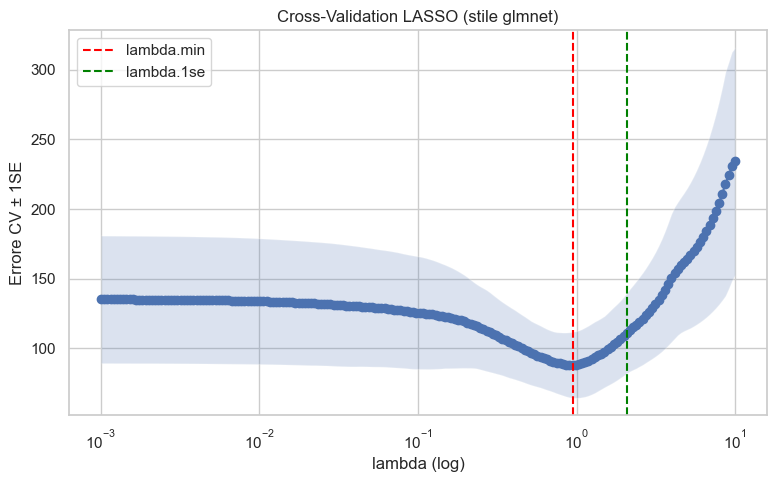

In [72]:
plt.plot(alphas, mse_mean, marker="o")
plt.fill_between(alphas, mse_mean-mse_std, mse_mean+mse_std, alpha=0.2)
plt.axvline(lambda_min, color="red", linestyle="--", label="lambda.min")
plt.axvline(lambda_1se, color="green", linestyle="--", label="lambda.1se")
plt.xscale("log")
plt.xlabel("lambda (log)")
plt.ylabel("Errore CV ± 1SE")
plt.title("Cross-Validation LASSO (stile glmnet)")
plt.legend()
plt.show()


In [73]:
# ------------------------------------------------------------
# FIT FINALE CON λ.min E λ.1se
# ------------------------------------------------------------
pipe_min = make_pipeline(
    StandardScaler(), 
    Lasso(alpha=lambda_min, max_iter=6000)
 )

pipe_min.fit(X, y)

coefs_min = pipe_min.named_steps["lasso"].coef_


pipe_1se = make_pipeline(
    StandardScaler(), 
    Lasso(alpha=lambda_1se, max_iter=6000)
    )

pipe_1se.fit(X, y)

coefs_1se = pipe_1se.named_steps["lasso"].coef_

# ------------------------------------------------------------
# FEATURE SELEZIONATE
# ------------------------------------------------------------
all_features = X.columns.tolist()

df_min = (
    pd.DataFrame({"feature": all_features, "coef": coefs_min})
    .loc[lambda d: d.coef != 0]
    .sort_values("coef", ascending=False)
)

df_1se = (
    pd.DataFrame({"feature": all_features, "coef": coefs_1se})
    .loc[lambda d: d.coef != 0]
    .sort_values("coef", ascending=False)
)

print("Variabili selezionate (λ.min):", df_min.shape[0])
display(df_min)

print("\nVariabili selezionate (λ.1se):", df_1se.shape[0])
display(df_1se)


Variabili selezionate (λ.min): 46


,feature,coef
700,age,9.059592
702,bmi,2.910038
270,bio_271,2.657283
701,sex,1.329862
367,bio_368,1.096035
670,bio_671,1.049664
409,bio_410,0.712609
147,bio_148,0.705244
128,bio_129,0.604202
436,bio_437,0.603673



Variabili selezionate (λ.1se): 10


,feature,coef
700,age,7.913865
702,bmi,2.291532
270,bio_271,2.202972
701,sex,0.360675
367,bio_368,0.342139
670,bio_671,0.318619
409,bio_410,0.060371
201,bio_202,-0.104281
371,bio_372,-0.326725
116,bio_117,-0.647272


Feature selezionate da entrambi i modelli: 10
{'bio_372', 'bio_202', 'bio_271', 'bio_117', 'bio_368', 'bio_671', 'bio_410', 'sex', 'bmi', 'age'}


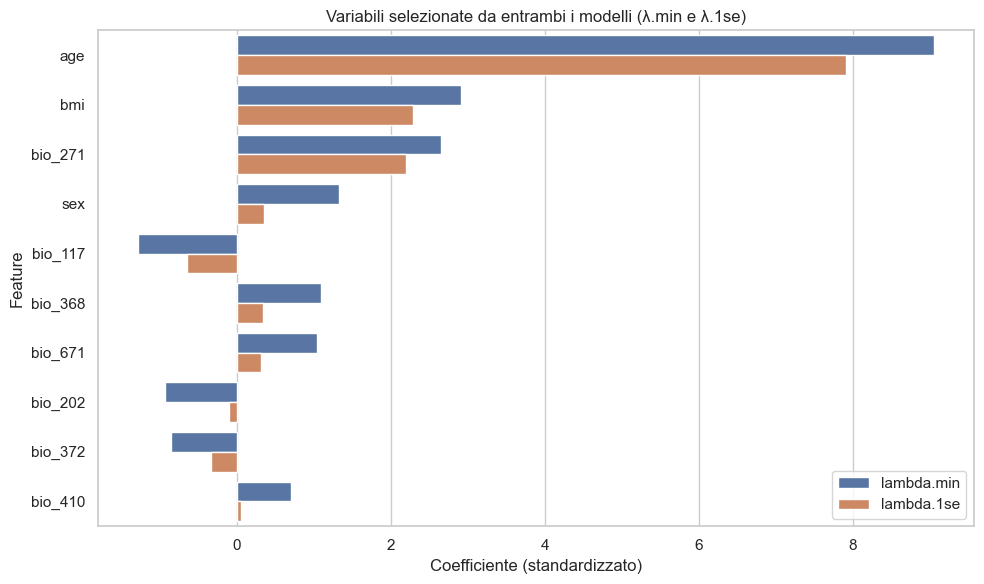

In [74]:
# ------------------------------------------------------------
# RICOSTRUZIONE DELLE FEATURE + COEFFICIENTI
# ------------------------------------------------------------
all_features = X.columns.tolist()

df_min = pd.DataFrame({
    "feature": all_features,
    "coef": coefs_min
}).query("coef != 0").assign(model="lambda.min")

df_1se = pd.DataFrame({
    "feature": all_features,
    "coef": coefs_1se
}).query("coef != 0").assign(model="lambda.1se")

# ------------------------------------------------------------
# INTERSEZIONE PERFETTA DELLE FEATURE SELEZIONATE
# ------------------------------------------------------------
set_min = set(df_min["feature"])
set_1se = set(df_1se["feature"])
common = set_min & set_1se

print("Feature selezionate da entrambi i modelli:", len(common))
print(common)   # <-- controllo rapido

# ------------------------------------------------------------
# DATAFRAME COMPLETO DELLE COMMON FEATURE
# ------------------------------------------------------------
df_common = pd.concat([df_min, df_1se], axis=0)
df_common = df_common[df_common["feature"].isin(common)].copy()

# Ordiniamo per magnitudine
df_common["abs_coef"] = df_common["coef"].abs()
df_common = df_common.sort_values("abs_coef", ascending=False)

# ------------------------------------------------------------
# BARPLOT DELLE VARIABILI COMUNI
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_common,
    x="coef",
    y="feature",
    hue="model",
    orient="h"
)
plt.xlabel("Coefficiente (standardizzato)")
plt.ylabel("Feature")
plt.title("Variabili selezionate da entrambi i modelli (λ.min e λ.1se)")
plt.legend(title="")
plt.tight_layout()
plt.show()


### Elastic Net

Elastic Net combina:
- **L1 (LASSO)** → può azzerare i coefficienti  
- **L2 (Ridge)** → stabilizza e tiene insieme variabili correlate  

`l1_ratio` controlla il mix:
- `1` → LASSO puro  
- `0` → Ridge puro  
- valore intermedio → Elastic Net  

In questa sezione **non** usiamo la cross-validation:  
l’obiettivo è *esplorare* come cambiano i coefficienti modificando:
- il valore della penalizzazione `alpha`
- il mix L1/L2 (`l1_ratio`)

Modifica i due numeri nella cella sotto e osserva:
- quante variabili restano selezionate  
- come cambiano i coefficienti  



🔧 Modello Elastic Net impostato con:
   λ (alpha)    = 2.072922
   l1_ratio     = 1

Variabili selezionate: 10 su 706

     feature      coef
700      age  7.913865
702      bmi  2.291531
270  bio_271  2.202972
116  bio_117 -0.647272
701      sex  0.360675
367  bio_368  0.342138
371  bio_372 -0.326725
670  bio_671  0.318619
201  bio_202 -0.104281
409  bio_410  0.060371


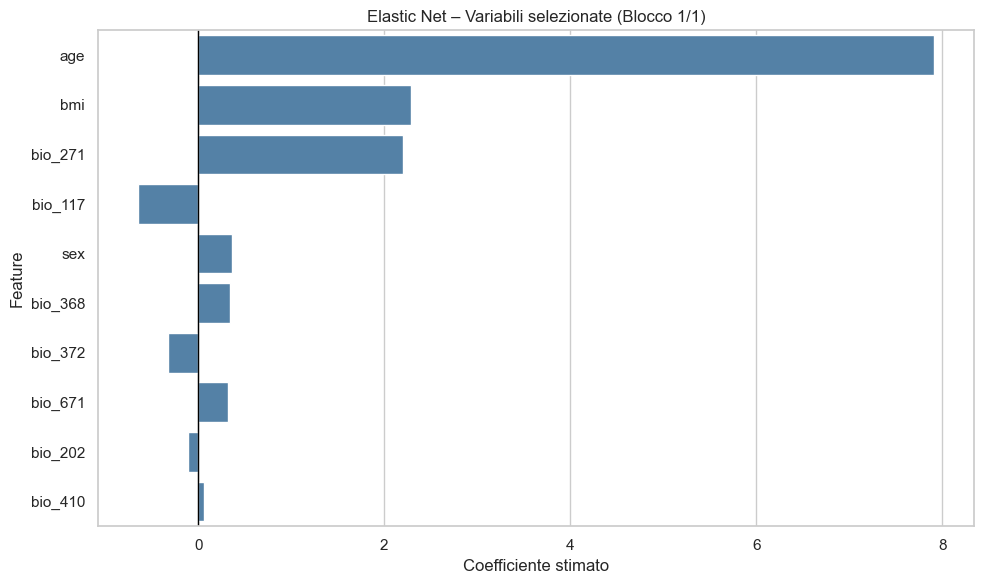

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

# ---------------------------------------------------------
# PARAMETRI DA MODIFICARE
# ---------------------------------------------------------
lambda_choice = 2.072922   # intensità penalizzazione (alpha)
l1_choice = 1             # 1 → LASSO, 0 → Ridge, valori intermedi → Elastic Net
# ---------------------------------------------------------

if not (0 <= l1_choice <= 1):
    raise ValueError("l1_ratio deve essere tra 0 e 1!")

print("\n🔧 Modello Elastic Net impostato con:")
print(f"   λ (alpha)    = {lambda_choice}")
print(f"   l1_ratio     = {l1_choice}\n")

# ---------------------------------------------------------
# FIT DEL MODELLO
# ---------------------------------------------------------
enet_demo = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=lambda_choice,
               l1_ratio=l1_choice,
               max_iter=6000)
)

enet_demo.fit(X, y)

# recupera i coefficienti dalla pipeline
coefs_demo = enet_demo.named_steps["elasticnet"].coef_

# aggiunge feature "demografiche"
all_features = X.columns.tolist()

# ---------------------------------------------------------
#  SELEZIONE FEATURE (COEFFICIENTI NON ZERO)
# ---------------------------------------------------------
df_demo = pd.DataFrame({
    "feature": all_features,
    "coef": coefs_demo
})

# Tenere solo coefficienti davvero ≠ 0
df_demo = df_demo.loc[df_demo["coef"] != 0]

active = df_demo.shape[0]
print(f"Variabili selezionate: {active} su {len(coefs_demo)}\n")

# Ordina per magnitudine del coefficiente
df_demo = df_demo.assign(abs_coef=df_demo["coef"].abs()) \
                 .sort_values("abs_coef", ascending=False)

print(df_demo[["feature", "coef"]])

# ---------------------------------------------------------
# BARPLOT IN CHUNK DA 10
# ---------------------------------------------------------
if active == 0:
    print(" Nessuna variabile selezionata. Prova a ridurre λ.")
else:
    chunk_size = 10
    n_chunks = int(np.ceil(active / chunk_size))

    for i in range(n_chunks):
        start = i * chunk_size
        end = start + chunk_size
        df_chunk = df_demo.iloc[start:end]

        plt.figure(figsize=(10, max(4, len(df_chunk) * 0.6)))
        sns.barplot(
            data=df_chunk,
            x="coef",
            y="feature",
            orient="h",
            color="steelblue"
        )
        plt.axvline(0, color="black", linewidth=1)
        plt.title(f"Elastic Net – Variabili selezionate (Blocco {i+1}/{n_chunks})")
        plt.xlabel("Coefficiente stimato")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
